# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
import timm
import torch_optimizer
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
import common as com
import pytorch_modeler as modeler
from pytorch_model import EfficientNet_b1 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/domain_adaptation/exp1/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    print(f'Machine {machine_type}', end=',')
    print(f'dev_train_size : {len(dev_train_paths)}', end=', ')
    dev_train_source_paths = [path for path in dev_train_paths if 'source' in path]
    print(f'source_size : {len(dev_train_source_paths)}', end=', ')
    dev_train_target_paths = [path for path in dev_train_paths if 'target' in path]
    print(f'target_size : {len(dev_train_target_paths)}', end=', ')
    # source mode
    dev_train_paths = dev_train_source_paths + dev_train_target_paths
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    print(f'adddev_train_size : {len(dev_train_paths)}', end=', ')
    add_dev_source_paths = [path for path in add_dev_paths if 'source' in path]
    print(f'source_size : {len(add_dev_source_paths)}', end=', ')
    add_dev_target_paths = [path for path in add_dev_paths if 'target' in path]
    print(f'target_size : {len(add_dev_target_paths)}')
    # source mode
    add_dev_paths = add_dev_source_paths + add_dev_target_paths
    print('==============================================================')
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

Machine fan,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine gearbox,dev_train_size : 3026, source_size : 3017, target_size : 9, adddev_train_size : 3026, source_size : 3105, target_size : 9
Machine pump,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine slider,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyCar,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine ToyTrain,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9
Machine valve,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3009, source_size : 3000, target_size : 9


In [9]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # parameter setting
    logger.info('TRAINING')
    model = Model(n_out=6)
    optimizer = torch_optimizer.RAdam(model.parameters())
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(dataloaders_dict['train']), epochs=config['param']['num_epochs'])
    output_dicts, model = modeler.run_training(model, dataloaders_dict, writer, optimizer)
    
    feature_out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    model_out_path = f'{MODEL_DIR}/{machine_type}_model.pkl'
    pd.to_pickle(output_dicts, feature_out_path)
    torch.save(model.state_dict(), model_out_path)
    logger.info(f'SAVE SUCCESS : {model_out_path}')
    
    com.toc()

# run

In [11]:
for machine_type in machine_types[0:]:
    run(machine_type, dev_paths)

2021-09-13 23:29:22,755 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-09-13 23:29:22,755 - 00_train.py - INFO - MAKE DATA_LOADER
2021-09-13 23:29:22,759 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
2021-09-13 23:30:06,333 - pytorch_modeler.py - INFO - epoch:1/50, tr_loss:79.542099, src_loss:7.811758, src_acc:0.370000, tgt_loss:7.934061, tgt_acc:0.380000,
100%|██████████| 5/5 [00:01<00:00,  3.08it/s]
2021-09-13 23:30:43,277 - pytorch_modeler.py - INFO - epoch:2/50, tr_loss:49.301983, src_loss:5.405408, src_acc:0.640000, tgt_loss:6.340278, tgt_acc:0.478333,
100%|██████████| 5/5 [00:01<00:00,  3.21it/s]
2021-09-13 23:31:18,887 - pytorch_modeler.py - INFO - epoch:3/50, tr_loss:28.079051, src_loss:3.609913, src_acc:0.820000, tgt_loss:4.661751, tgt_acc:0.646667,
100%|██████████| 5/5 [00:01<00:00,  3.01it/s]
2021-09-13 23:31:54,948 - pytorch_modeler.py - INFO - epoch:4/50, tr_loss:16.646667, src_loss:3.845954, src_acc:0.806667, tgt_loss:4.801641, tgt_acc:0.688333,
100%|██████████| 5/5 [00:01<00:00,  3.05it/s]
2021-09-13 23:32:30,957 - pytorch_modeler.py - INFO - epoch:5/50, tr_loss:11.322578, src_loss:3.301138, src_acc:0.853333, tgt_loss:3.2

100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
2021-09-13 23:46:13,882 - pytorch_modeler.py - INFO - epoch:28/50, tr_loss:5.835237, src_loss:4.132436, src_acc:0.871667, tgt_loss:6.459700, tgt_acc:0.781667,
100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
2021-09-13 23:46:49,519 - pytorch_modeler.py - INFO - epoch:29/50, tr_loss:5.416006, src_loss:5.185145, src_acc:0.878333, tgt_loss:6.832990, tgt_acc:0.783333,
100%|██████████| 5/5 [00:01<00:00,  3.06it/s]
2021-09-13 23:47:25,141 - pytorch_modeler.py - INFO - epoch:30/50, tr_loss:6.182867, src_loss:4.761107, src_acc:0.823333, tgt_loss:7.138636, tgt_acc:0.701667,
100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
2021-09-13 23:48:00,851 - pytorch_modeler.py - INFO - epoch:31/50, tr_loss:9.428416, src_loss:5.781756, src_acc:0.848333, tgt_loss:8.294848, tgt_acc:0.718333,
100%|██████████| 5/5 [00:01<00:00,  3.04it/s]
2021-09-13 23:48:36,876 - pytorch_modeler.py - INFO - epoch:32/50, tr_loss:4.889551, src_loss:3.034333, src_acc:0.896667, tgt_loss:3.4

elapsed time: 1799.666927338 [sec]
use: cuda:0


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]
2021-09-13 23:59:58,238 - pytorch_modeler.py - INFO - epoch:1/50, tr_loss:80.975360, src_loss:9.196552, src_acc:0.363517, tgt_loss:9.351503, tgt_acc:0.368992,
100%|██████████| 6/6 [00:01<00:00,  3.31it/s]
2021-09-14 00:00:34,594 - pytorch_modeler.py - INFO - epoch:2/50, tr_loss:51.435855, src_loss:7.985934, src_acc:0.477690, tgt_loss:8.661470, tgt_acc:0.458915,
100%|██████████| 6/6 [00:01<00:00,  3.34it/s]
2021-09-14 00:01:11,093 - pytorch_modeler.py - INFO - epoch:3/50, tr_loss:33.010973, src_loss:6.648607, src_acc:0.572178, tgt_loss:9.005794, tgt_acc:0.489922,
100%|██████████| 6/6 [00:01<00:00,  3.20it/s]
2021-09-14 00:01:47,552 - pytorch_modeler.py - INFO - epoch:4/50, tr_loss:24.559566, src_loss:6.431364, src_acc:0.576115, tgt_loss:7.650261, tgt_acc:0.562791,
100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
2021-09-14 00:02:23,940 - pytorch_modeler.py - INFO - epoch:5/50, tr_loss:18.667390, src_loss:6.224071, src_acc:0.610236, tgt_loss:8.8

100%|██████████| 6/6 [00:01<00:00,  3.31it/s]
2021-09-14 00:16:35,184 - pytorch_modeler.py - INFO - epoch:28/50, tr_loss:3.239303, src_loss:10.016400, src_acc:0.620735, tgt_loss:13.288451, tgt_acc:0.539535,
100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
2021-09-14 00:17:12,125 - pytorch_modeler.py - INFO - epoch:29/50, tr_loss:2.620009, src_loss:8.549838, src_acc:0.670604, tgt_loss:14.108965, tgt_acc:0.547287,
100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
2021-09-14 00:17:49,040 - pytorch_modeler.py - INFO - epoch:30/50, tr_loss:2.516315, src_loss:10.500078, src_acc:0.657480, tgt_loss:14.351610, tgt_acc:0.570543,
100%|██████████| 6/6 [00:01<00:00,  3.36it/s]
2021-09-14 00:18:26,111 - pytorch_modeler.py - INFO - epoch:31/50, tr_loss:2.941376, src_loss:9.275279, src_acc:0.677165, tgt_loss:15.082086, tgt_acc:0.579845,
100%|██████████| 6/6 [00:01<00:00,  3.42it/s]
2021-09-14 00:19:03,291 - pytorch_modeler.py - INFO - epoch:32/50, tr_loss:2.916398, src_loss:11.653192, src_acc:0.628609, tgt_l

elapsed time: 1844.996851444 [sec]
use: cuda:0


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
2021-09-14 00:31:41,566 - pytorch_modeler.py - INFO - epoch:1/50, tr_loss:77.928170, src_loss:6.694440, src_acc:0.541667, tgt_loss:6.150605, tgt_acc:0.591667,
100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
2021-09-14 00:32:16,740 - pytorch_modeler.py - INFO - epoch:2/50, tr_loss:50.871990, src_loss:4.685310, src_acc:0.576667, tgt_loss:4.389580, tgt_acc:0.613333,
100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
2021-09-14 00:32:51,928 - pytorch_modeler.py - INFO - epoch:3/50, tr_loss:26.925027, src_loss:4.414212, src_acc:0.655000, tgt_loss:3.852082, tgt_acc:0.670000,
100%|██████████| 5/5 [00:01<00:00,  3.09it/s]
2021-09-14 00:33:27,277 - pytorch_modeler.py - INFO - epoch:4/50, tr_loss:18.782184, src_loss:4.866284, src_acc:0.663333, tgt_loss:4.055218, tgt_acc:0.705000,
100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
2021-09-14 00:34:02,902 - pytorch_modeler.py - INFO - epoch:5/50, tr_loss:17.074919, src_loss:4.423135, src_acc:0.665000, tgt_loss:4.1

100%|██████████| 5/5 [00:01<00:00,  3.07it/s]
2021-09-14 00:47:39,979 - pytorch_modeler.py - INFO - epoch:28/50, tr_loss:7.022736, src_loss:7.194334, src_acc:0.703333, tgt_loss:4.339832, tgt_acc:0.773333,
100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
2021-09-14 00:48:15,640 - pytorch_modeler.py - INFO - epoch:29/50, tr_loss:7.164931, src_loss:4.864227, src_acc:0.766667, tgt_loss:3.652279, tgt_acc:0.768333,
100%|██████████| 5/5 [00:01<00:00,  2.97it/s]
2021-09-14 00:48:51,331 - pytorch_modeler.py - INFO - epoch:30/50, tr_loss:11.394407, src_loss:4.623230, src_acc:0.778333, tgt_loss:3.457988, tgt_acc:0.820000,
100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
2021-09-14 00:49:26,943 - pytorch_modeler.py - INFO - epoch:31/50, tr_loss:9.676086, src_loss:4.383300, src_acc:0.803333, tgt_loss:3.313485, tgt_acc:0.850000,
100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
2021-09-14 00:50:02,905 - pytorch_modeler.py - INFO - epoch:32/50, tr_loss:8.420004, src_loss:4.301139, src_acc:0.788333, tgt_loss:2.

elapsed time: 1841.581946611 [sec]
use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]
2021-09-14 01:02:48,900 - pytorch_modeler.py - INFO - epoch:1/50, tr_loss:74.245741, src_loss:5.772120, src_acc:0.648693, tgt_loss:6.913628, tgt_acc:0.495017,
100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
2021-09-14 01:03:24,145 - pytorch_modeler.py - INFO - epoch:2/50, tr_loss:27.713701, src_loss:2.613452, src_acc:0.807190, tgt_loss:9.288092, tgt_acc:0.458472,
100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
2021-09-14 01:03:59,367 - pytorch_modeler.py - INFO - epoch:3/50, tr_loss:12.832431, src_loss:2.378115, src_acc:0.813725, tgt_loss:9.970917, tgt_acc:0.486711,
100%|██████████| 5/5 [00:01<00:00,  3.06it/s]
2021-09-14 01:04:34,757 - pytorch_modeler.py - INFO - epoch:4/50, tr_loss:7.223450, src_loss:3.028034, src_acc:0.821895, tgt_loss:11.459921, tgt_acc:0.460133,
100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
2021-09-14 01:05:10,079 - pytorch_modeler.py - INFO - epoch:5/50, tr_loss:7.601504, src_loss:5.176723, src_acc:0.759804, tgt_loss:17.5

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
2021-09-14 01:18:46,954 - pytorch_modeler.py - INFO - epoch:28/50, tr_loss:1.737672, src_loss:3.446486, src_acc:0.836601, tgt_loss:17.904796, tgt_acc:0.443522,
100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
2021-09-14 01:19:22,495 - pytorch_modeler.py - INFO - epoch:29/50, tr_loss:3.982200, src_loss:3.592328, src_acc:0.841503, tgt_loss:17.890201, tgt_acc:0.488372,
100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
2021-09-14 01:19:58,038 - pytorch_modeler.py - INFO - epoch:30/50, tr_loss:6.625742, src_loss:3.827557, src_acc:0.846405, tgt_loss:17.469961, tgt_acc:0.400332,
100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
2021-09-14 01:20:33,790 - pytorch_modeler.py - INFO - epoch:31/50, tr_loss:4.366889, src_loss:3.807530, src_acc:0.862745, tgt_loss:18.894353, tgt_acc:0.416944,
100%|██████████| 5/5 [00:01<00:00,  3.06it/s]
2021-09-14 01:21:09,498 - pytorch_modeler.py - INFO - epoch:32/50, tr_loss:1.702320, src_loss:1.976357, src_acc:0.901961, tgt_loss

elapsed time: 1866.094063044 [sec]
use: cuda:0


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
2021-09-14 01:33:21,790 - pytorch_modeler.py - INFO - epoch:1/50, tr_loss:66.993649, src_loss:5.044271, src_acc:0.601667, tgt_loss:5.851902, tgt_acc:0.448333,
100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
2021-09-14 01:33:56,973 - pytorch_modeler.py - INFO - epoch:2/50, tr_loss:24.309558, src_loss:3.368634, src_acc:0.726667, tgt_loss:3.424896, tgt_acc:0.763333,
100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
2021-09-14 01:34:32,275 - pytorch_modeler.py - INFO - epoch:3/50, tr_loss:12.171202, src_loss:3.679012, src_acc:0.763333, tgt_loss:1.467533, tgt_acc:0.878333,
100%|██████████| 5/5 [00:01<00:00,  3.03it/s]
2021-09-14 01:35:07,556 - pytorch_modeler.py - INFO - epoch:4/50, tr_loss:10.431400, src_loss:3.706192, src_acc:0.770000, tgt_loss:1.497881, tgt_acc:0.886667,
100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
2021-09-14 01:35:42,738 - pytorch_modeler.py - INFO - epoch:5/50, tr_loss:9.977125, src_loss:2.671323, src_acc:0.813333, tgt_loss:1.67

100%|██████████| 5/5 [00:01<00:00,  3.05it/s]
2021-09-14 01:49:18,519 - pytorch_modeler.py - INFO - epoch:28/50, tr_loss:4.245226, src_loss:4.963806, src_acc:0.845000, tgt_loss:0.844165, tgt_acc:0.951667,
100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
2021-09-14 01:49:54,170 - pytorch_modeler.py - INFO - epoch:29/50, tr_loss:5.454491, src_loss:3.934421, src_acc:0.841667, tgt_loss:2.438187, tgt_acc:0.908333,
100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
2021-09-14 01:50:29,830 - pytorch_modeler.py - INFO - epoch:30/50, tr_loss:6.393746, src_loss:3.237121, src_acc:0.841667, tgt_loss:2.072394, tgt_acc:0.861667,
100%|██████████| 5/5 [00:01<00:00,  3.22it/s]
2021-09-14 01:51:05,341 - pytorch_modeler.py - INFO - epoch:31/50, tr_loss:3.833704, src_loss:6.313113, src_acc:0.805000, tgt_loss:1.778510, tgt_acc:0.883333,
100%|██████████| 5/5 [00:01<00:00,  3.16it/s]
2021-09-14 01:51:40,913 - pytorch_modeler.py - INFO - epoch:32/50, tr_loss:2.997913, src_loss:4.766909, src_acc:0.870000, tgt_loss:2.9

elapsed time: 1831.155756950 [sec]
use: cuda:0


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
2021-09-14 02:04:02,004 - pytorch_modeler.py - INFO - epoch:1/50, tr_loss:64.636118, src_loss:3.289342, src_acc:0.760000, tgt_loss:5.036308, tgt_acc:0.600000,
100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
2021-09-14 02:04:37,378 - pytorch_modeler.py - INFO - epoch:2/50, tr_loss:18.562974, src_loss:0.228449, src_acc:0.993333, tgt_loss:4.384299, tgt_acc:0.666667,
100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
2021-09-14 02:05:12,578 - pytorch_modeler.py - INFO - epoch:3/50, tr_loss:8.294657, src_loss:0.273198, src_acc:0.983333, tgt_loss:3.828289, tgt_acc:0.666667,
100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
2021-09-14 02:05:47,762 - pytorch_modeler.py - INFO - epoch:4/50, tr_loss:6.570444, src_loss:0.294886, src_acc:0.978333, tgt_loss:2.813335, tgt_acc:0.725000,
100%|██████████| 5/5 [00:01<00:00,  3.20it/s]
2021-09-14 02:06:22,991 - pytorch_modeler.py - INFO - epoch:5/50, tr_loss:5.828030, src_loss:0.095709, src_acc:0.993333, tgt_loss:0.9880

100%|██████████| 5/5 [00:01<00:00,  3.18it/s]
2021-09-14 02:19:58,360 - pytorch_modeler.py - INFO - epoch:28/50, tr_loss:4.411715, src_loss:0.192586, src_acc:0.991667, tgt_loss:1.932794, tgt_acc:0.848333,
100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
2021-09-14 02:20:33,993 - pytorch_modeler.py - INFO - epoch:29/50, tr_loss:1.507416, src_loss:0.490416, src_acc:0.978333, tgt_loss:0.620283, tgt_acc:0.958333,
100%|██████████| 5/5 [00:01<00:00,  3.12it/s]
2021-09-14 02:21:09,491 - pytorch_modeler.py - INFO - epoch:30/50, tr_loss:5.621623, src_loss:0.042245, src_acc:0.998333, tgt_loss:0.075214, tgt_acc:0.995000,
100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
2021-09-14 02:21:45,080 - pytorch_modeler.py - INFO - epoch:31/50, tr_loss:1.360928, src_loss:0.167811, src_acc:0.986667, tgt_loss:0.129626, tgt_acc:0.995000,
100%|██████████| 5/5 [00:01<00:00,  3.11it/s]
2021-09-14 02:22:20,737 - pytorch_modeler.py - INFO - epoch:32/50, tr_loss:3.495125, src_loss:0.427272, src_acc:0.976667, tgt_loss:0.2

elapsed time: 1839.230585337 [sec]
use: cuda:0


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
2021-09-14 02:34:31,900 - pytorch_modeler.py - INFO - epoch:1/50, tr_loss:80.098272, src_loss:7.787770, src_acc:0.461667, tgt_loss:8.094548, tgt_acc:0.428333,
100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
2021-09-14 02:35:07,084 - pytorch_modeler.py - INFO - epoch:2/50, tr_loss:37.787109, src_loss:2.321640, src_acc:0.846667, tgt_loss:6.908664, tgt_acc:0.596667,
100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
2021-09-14 02:35:42,324 - pytorch_modeler.py - INFO - epoch:3/50, tr_loss:11.158744, src_loss:1.498267, src_acc:0.905000, tgt_loss:7.307301, tgt_acc:0.683333,
100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
2021-09-14 02:36:17,642 - pytorch_modeler.py - INFO - epoch:4/50, tr_loss:3.644393, src_loss:1.582802, src_acc:0.895000, tgt_loss:8.925574, tgt_acc:0.680000,
100%|██████████| 5/5 [00:01<00:00,  3.14it/s]
2021-09-14 02:36:52,857 - pytorch_modeler.py - INFO - epoch:5/50, tr_loss:4.261710, src_loss:1.123222, src_acc:0.921667, tgt_loss:8.310

100%|██████████| 5/5 [00:01<00:00,  3.09it/s]
2021-09-14 02:50:28,660 - pytorch_modeler.py - INFO - epoch:28/50, tr_loss:4.300303, src_loss:3.316489, src_acc:0.876667, tgt_loss:5.216681, tgt_acc:0.830000,
100%|██████████| 5/5 [00:01<00:00,  3.13it/s]
2021-09-14 02:51:04,158 - pytorch_modeler.py - INFO - epoch:29/50, tr_loss:7.536478, src_loss:1.786989, src_acc:0.913333, tgt_loss:6.518558, tgt_acc:0.786667,
100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
2021-09-14 02:51:39,750 - pytorch_modeler.py - INFO - epoch:30/50, tr_loss:2.615011, src_loss:1.639365, src_acc:0.913333, tgt_loss:5.216288, tgt_acc:0.815000,
100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
2021-09-14 02:52:15,407 - pytorch_modeler.py - INFO - epoch:31/50, tr_loss:5.302135, src_loss:1.446729, src_acc:0.933333, tgt_loss:7.661782, tgt_acc:0.763333,
100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
2021-09-14 02:52:51,019 - pytorch_modeler.py - INFO - epoch:32/50, tr_loss:1.423700, src_loss:1.531607, src_acc:0.928333, tgt_loss:4.1

elapsed time: 1830.835705042 [sec]


In [12]:
feature_out_path = f'{OUT_FEATURE_DIR}/{machine_types[0]}_features.pkl'
tst = pd.read_pickle(feature_out_path)

In [13]:
tst['val_tgt']

{'loss': 4.890389651060104,
 'feature': array([[-0.1992 , -0.1562 ,  0.02083, ..., -0.1526 , -0.2339 , -0.2478 ],
        [-0.238  , -0.0739 ,  0.1796 , ..., -0.1956 , -0.254  , -0.1779 ],
        [-0.1815 , -0.1837 ,  0.00535, ..., -0.1604 , -0.1888 , -0.1971 ],
        ...,
        [ 0.1542 , -0.02217, -0.2179 , ..., -0.1527 , -0.227  ,  0.2032 ],
        [-0.2222 , -0.1176 , -0.183  , ...,  0.04623, -0.2083 ,  0.1747 ],
        [-0.0779 , -0.0692 , -0.2052 , ...,  0.02045, -0.197  ,  0.0547 ]],
       dtype=float16),
 'label': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0

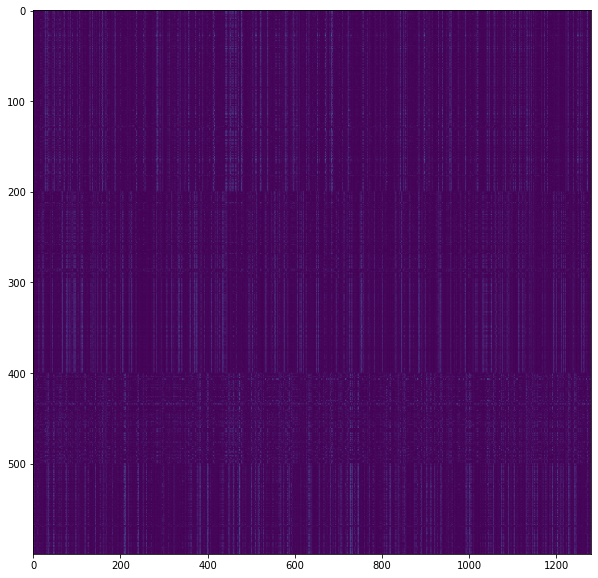

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(tst['val_src']['feature'].astype(float), aspect='auto')

In [29]:
tst['val_src']['feature'].shape

(600, 1280)